In [ ]:
import torch

print(torch.cuda.is_available())
print("Num GPUS: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name())



In [ ]:
from ultralytics import YOLO

model = YOLO('yolo11n-seg.pt')

dataset_path = r"C:\Users\johnb\Projects\pokemoncarddetection\yolov8obb-object-detection\pokemoncarddetector.v7i.yolov11-2"

results = model.train(data=f'{dataset_path}\data.yaml', epochs=100, imgsz=640, cache=False, single_cls=True, batch=32)

In [2]:
from ultralytics import YOLO

model = YOLO('../runs/segment/train5/weights/best.pt')
model.export(format='coreml')

Ultralytics 8.3.25 🚀 Python-3.10.14 torch-2.5.1 CPU (Apple M1 Pro)
YOLO11n-seg summary (fused): 265 layers, 2,834,763 parameters, 0 gradients, 10.2 GFLOPs

PyTorch: starting from '../runs/segment/train5/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) ((1, 37, 8400), (1, 32, 160, 160)) (5.7 MB)

CoreML: starting export with coremltools 8.0...


Tuple detected at graph output. This will be flattened in the converted model.
Running MIL backend_mlprogram pipeline: 100%|██████████| 12/12 [00:00<00:00, 77.40 passes/s]


CoreML: export success ✅ 15.2s, saved as '../runs/segment/train5/weights/best.mlpackage' (5.6 MB)

Export complete (15.5s)
Results saved to /Users/johnmarquez/projects/PokemonCardDetectionApp/runs/segment/train5/weights
Predict:         yolo predict task=segment model=../runs/segment/train5/weights/best.mlpackage imgsz=640  
Validate:        yolo val task=segment model=../runs/segment/train5/weights/best.mlpackage imgsz=640 data=C:\Users\johnb\Projects\pokemoncarddetection\yolov8obb-object-detection\pokemoncarddetector.v7i.yolov11-2\data.yaml  
Visualize:       https://netron.app


'../runs/segment/train5/weights/best.mlpackage'

In [1]:
from ultralytics import YOLO

model = YOLO(r'C:\Users\johnb\Projects\pokemoncarddetection\runs\segment\train5\weights\best.pt')
test_path = r"C:\Users\johnb\Projects\pokemoncarddetection\yolov8obb-object-detection\test\images"

import os
import supervision as sv
import cv2
import matplotlib.pyplot as plt

image_files = [f for f in os.listdir(test_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
current_image_index = 0
 
# random_file = random.choice(os.listdir(fr'{test_path}\images'))
# file_name = os.path.join(fr'{test_path}\images', random_file)

def show_image(index):

    img_path = os.path.join(test_path, '462293616_933057372181563_7962881392829318133_n.jpg')
    results = model(img_path)
    detections = sv.Detections.from_ultralytics(results[0])

    annotator = sv.MaskAnnotator()
    annotated_frame = annotator.annotate(
        scene=cv2.imread(img_path),
        detections=detections,
    )

    sv.plot_image(annotated_frame)

show_image(1)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/Users/johnmarquez/Library/Application Support/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\johnb\\Projects\\pokemoncarddetection\\runs\\segment\\train5\\weights\\best.pt'


image 1/1 C:\Users\johnb\Projects\pokemoncarddetection\yolov8obb-object-detection\test\images\463808013_2052600941823512_5837094411262231169_n.jpg: 640x480 1 card, 53.0ms
Speed: 1.0ms preprocess, 53.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


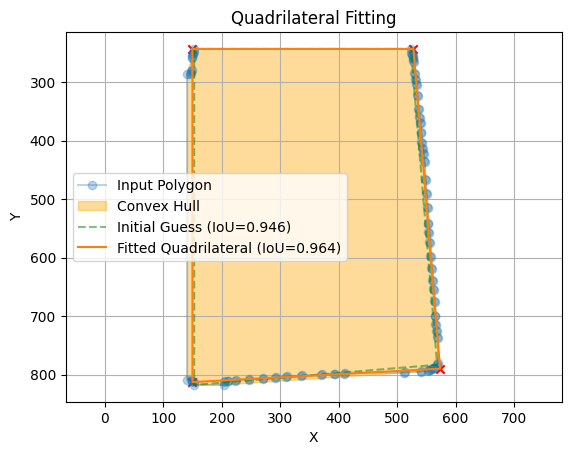

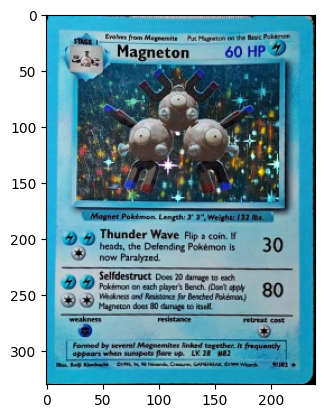

In [7]:
import numpy as np
from quadrilateral_fitter import QuadrilateralFitter
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

image_file = os.path.join(test_path, '463808013_2052600941823512_5837094411262231169_n.jpg')

results = model(image_file)

mask = results[0].masks.xy[0]

# Fit Quadrilateral from the Mask
fitter = QuadrilateralFitter(polygon=mask)
quadrilateral = fitter.fit(simplify_polygons_larger_than=4)

fitter.plot()

img = cv2.imread(image_file)


b_mask = np.zeros(img.shape[:2], np.uint8)
contour = mask.astype(np.int32).reshape(-1, 1, 2)

_ = cv2.drawContours(b_mask, [contour], -1, (255, 255, 255), cv2.FILLED)

mask3ch = cv2.cvtColor(b_mask, cv2.COLOR_GRAY2BGR)
isolated = cv2.bitwise_and(mask3ch, img)

plt.imshow(isolated)

h, w = isolated.shape[:2]

quadrilateral = np.array(quadrilateral, dtype=np.float32)

min_x, min_y = np.min(quadrilateral, axis=0)
max_x, max_y = np.max(quadrilateral, axis=0)

# Define the destiny points for the perspective correction
destiny_points = np.array(((0, 0), (240, 0),
                            (240, 330), (0, 330)), dtype=np.float32)

# Calculate the homography matrix from the quadrilateral to the rectangle
homography_matrix, _ = cv2.findHomography(srcPoints=quadrilateral, dstPoints=destiny_points)
# Warp the image using the homography matrix
warped_image = cv2.warpPerspective(src=isolated, M=homography_matrix, dsize=(240, 330))

plt.imshow(warped_image)


Top n closest images:
base4-9.png with distance 54


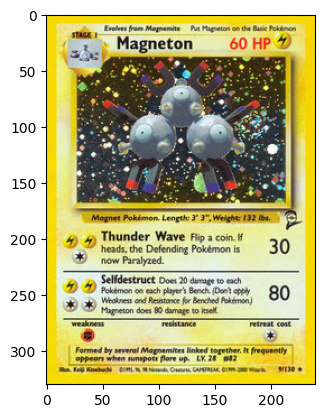

In [8]:
from card_matching.pokemoncardmatcher import PokemonCardMatcher
from pathlib import Path
from PIL import Image

def display_cards(matches):
    print('Top n closest images:')

    for entry in matches[:1]:
        filename = entry['filename']
        distance = entry['distance']
        print(f'{filename} with distance {distance}')
        image_path = os.path.join('../pokemon-images-training/pokemon-tcg-images', f'{filename}')
        read_image = cv2.imread(image_path)

        read_image = cv2.cvtColor(read_image, cv2.COLOR_BGR2RGB)

        if read_image is not None:
            plt.imshow(read_image)

gray_image = cv2.cvtColor(warped_image, cv2.COLOR_BGR2GRAY)

image = Image.fromarray(gray_image)

card_matcher = PokemonCardMatcher(Path('../card_matching/pokemon-tcg-image-data.csv'))
matches = card_matcher.get_top_n_matches(image)

display_cards(matches)



